In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [8]:
print([
'current_temp_f',
 'current_humidity',
 'pm2_5_atm',
 'p_0_3_um',
 'p_0_5_um',
 'p_1_0_um',
 'p_2_5_um',
 'p_5_0_um',
 'p_10_0_um',
#  'current_temp_fcount',
#  'current_humiditycount',
#  'pm2_5_atmcount',
#  'p_0_3_umcount',
#  'p_0_5_umcount',
#  'p_1_0_umcount',
#  'p_2_5_umcount',
#  'p_5_0_umcount',
#  'p_10_0_umcount'
 ])

['current_temp_f', 'current_humidity', 'pm2_5_atm', 'p_0_3_um', 'p_0_5_um', 'p_1_0_um', 'p_2_5_um', 'p_5_0_um', 'p_10_0_um']


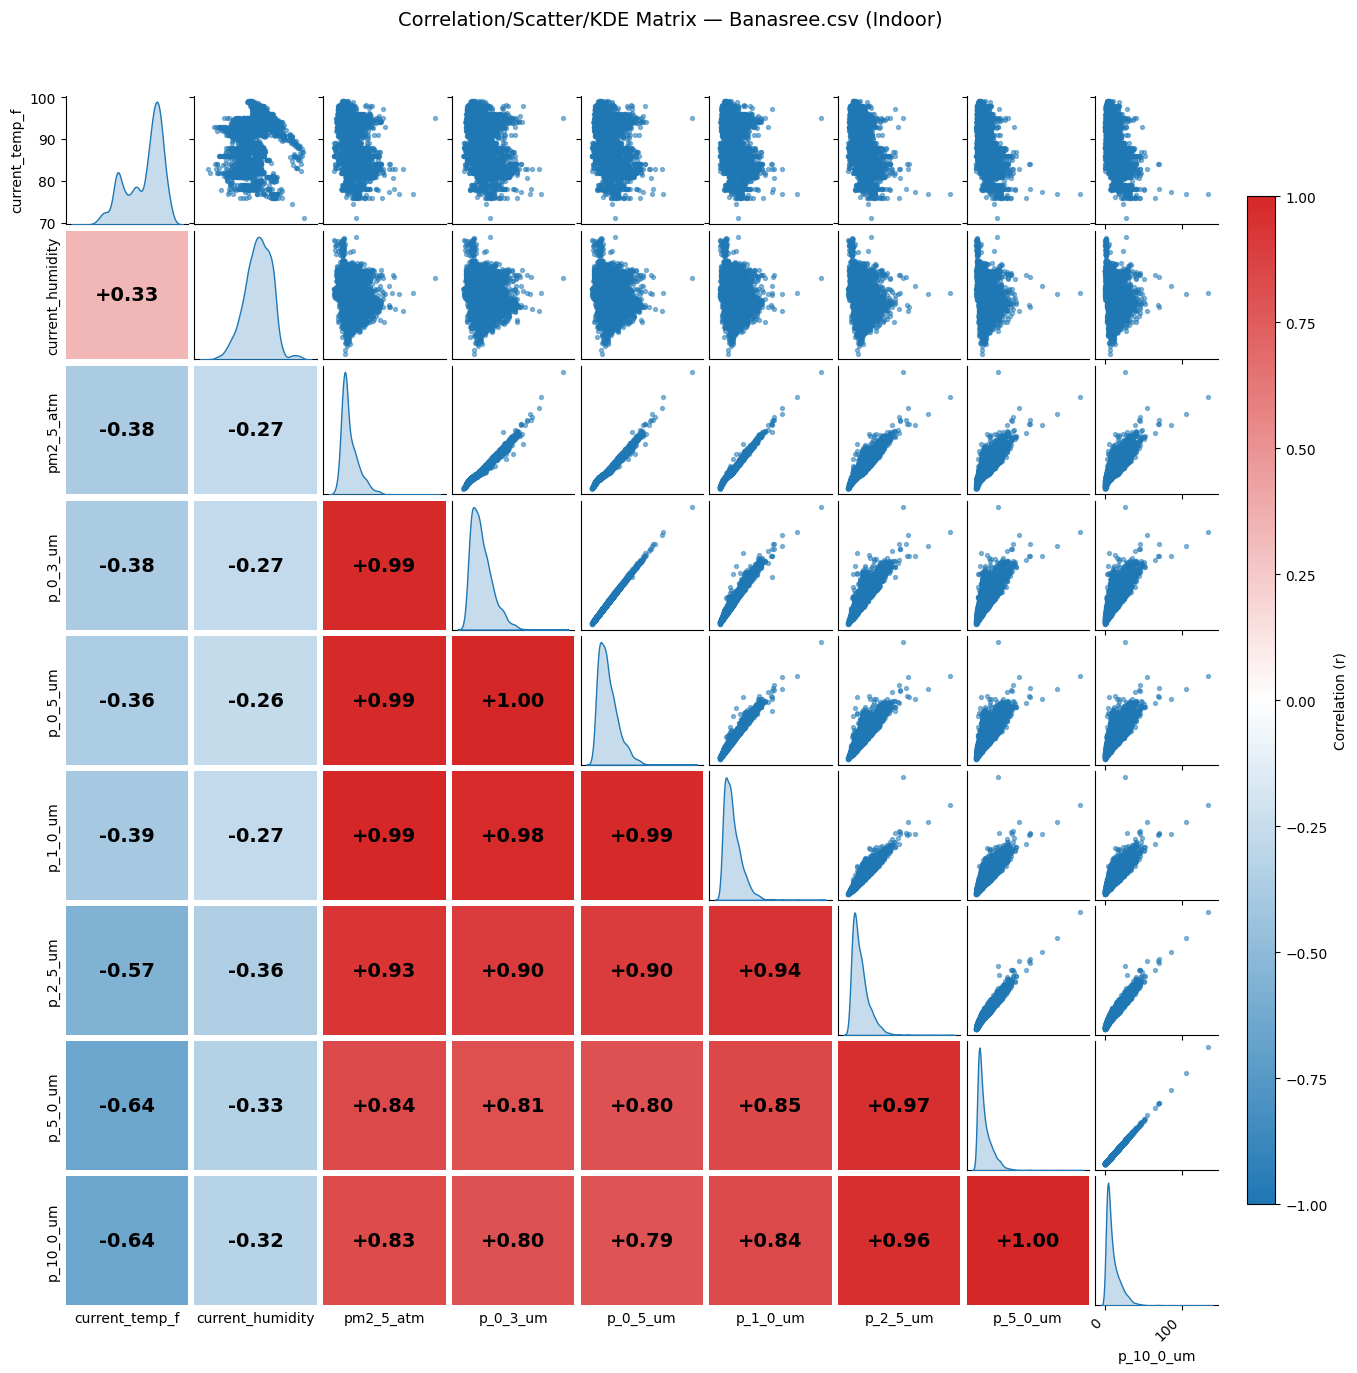

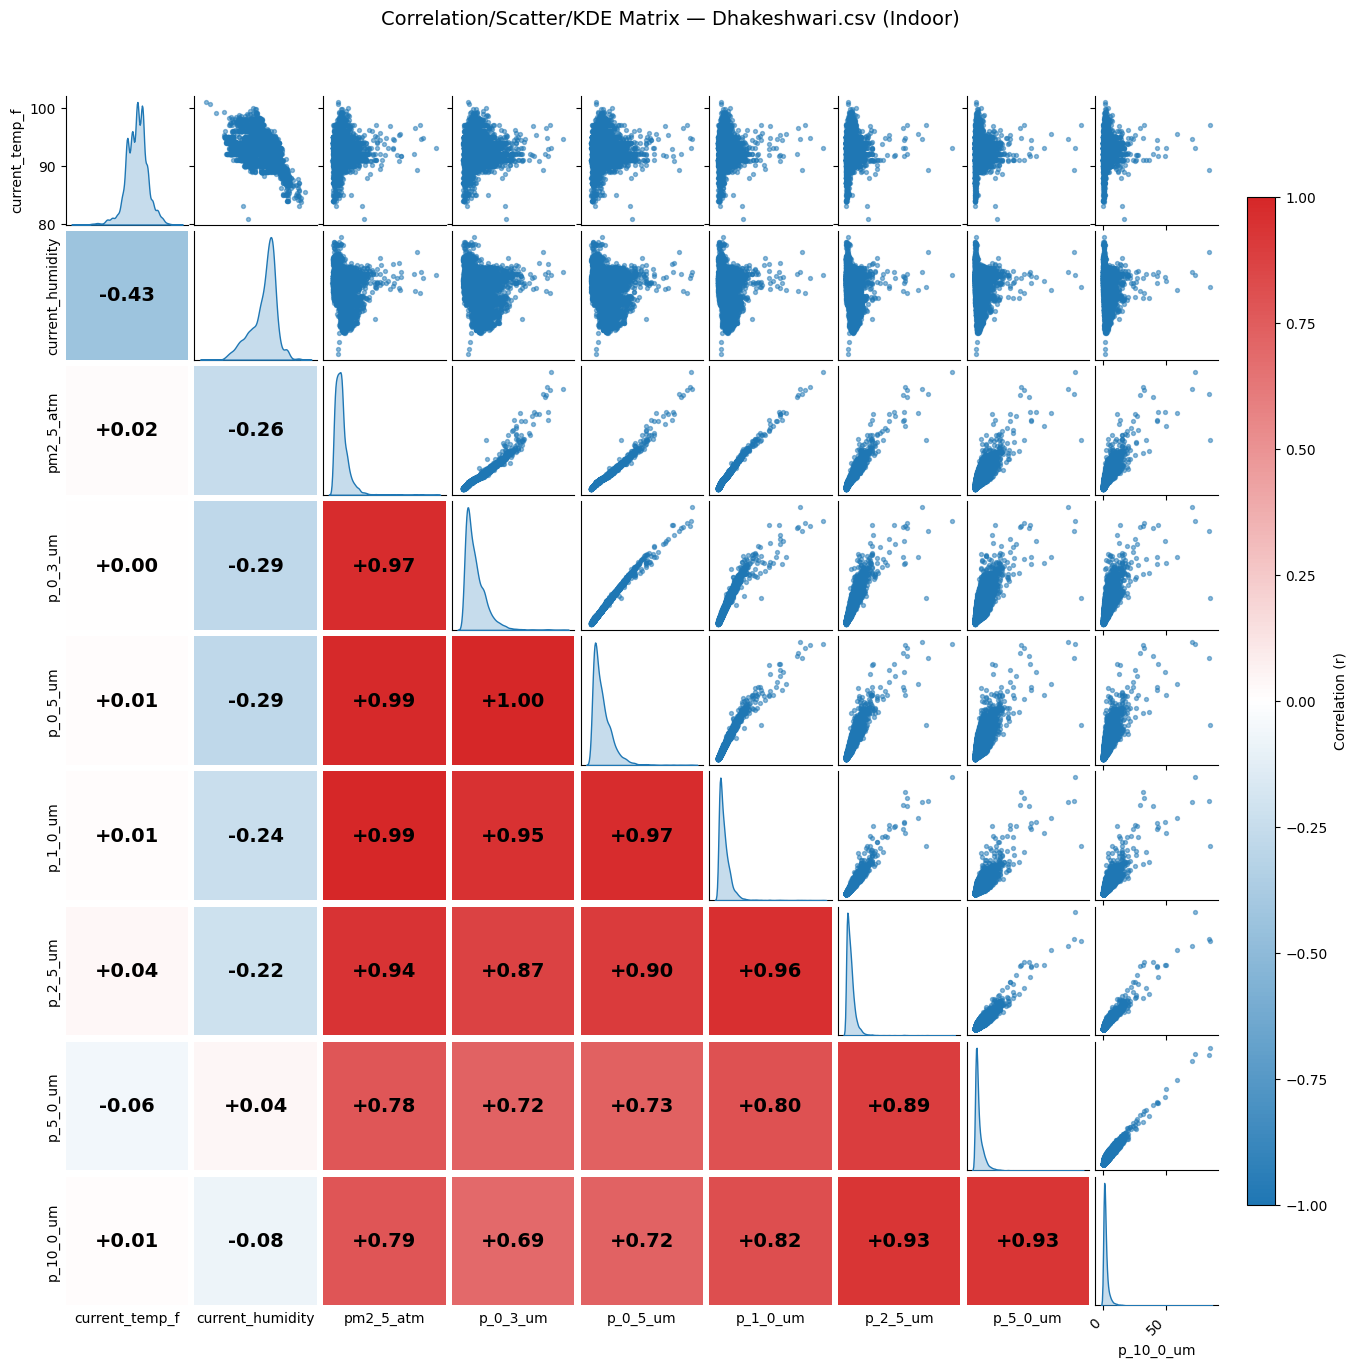

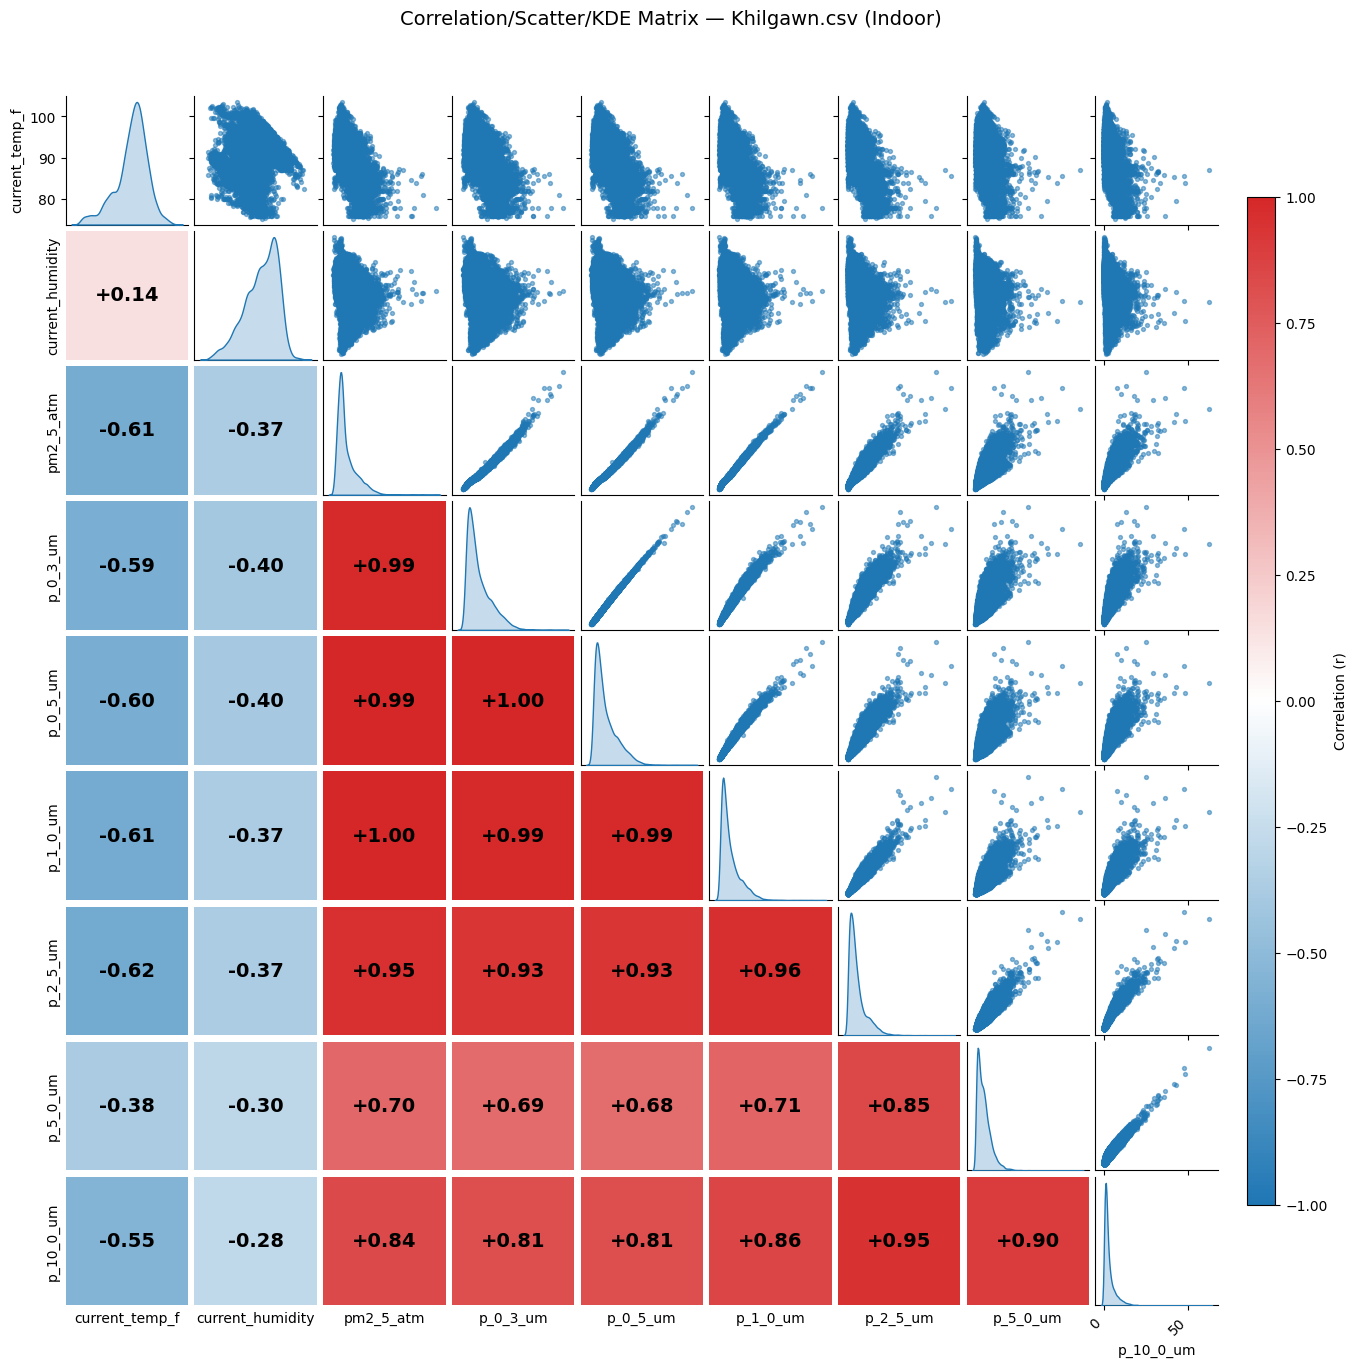

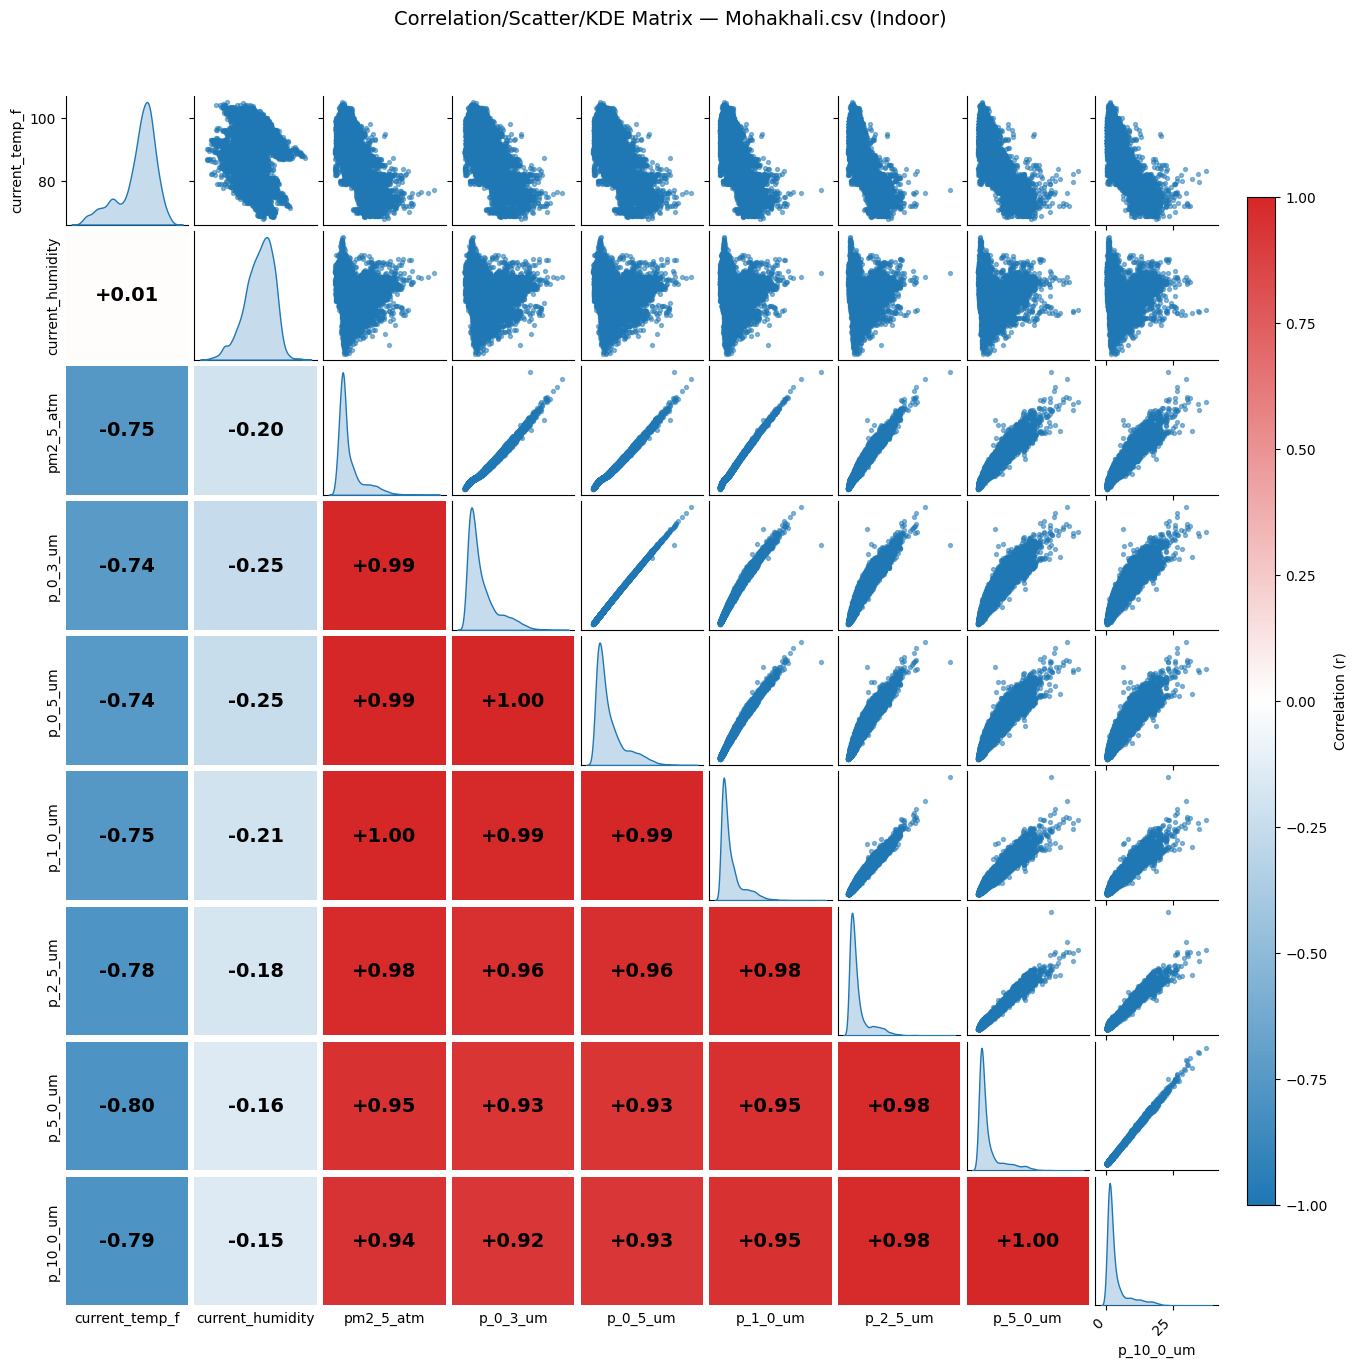

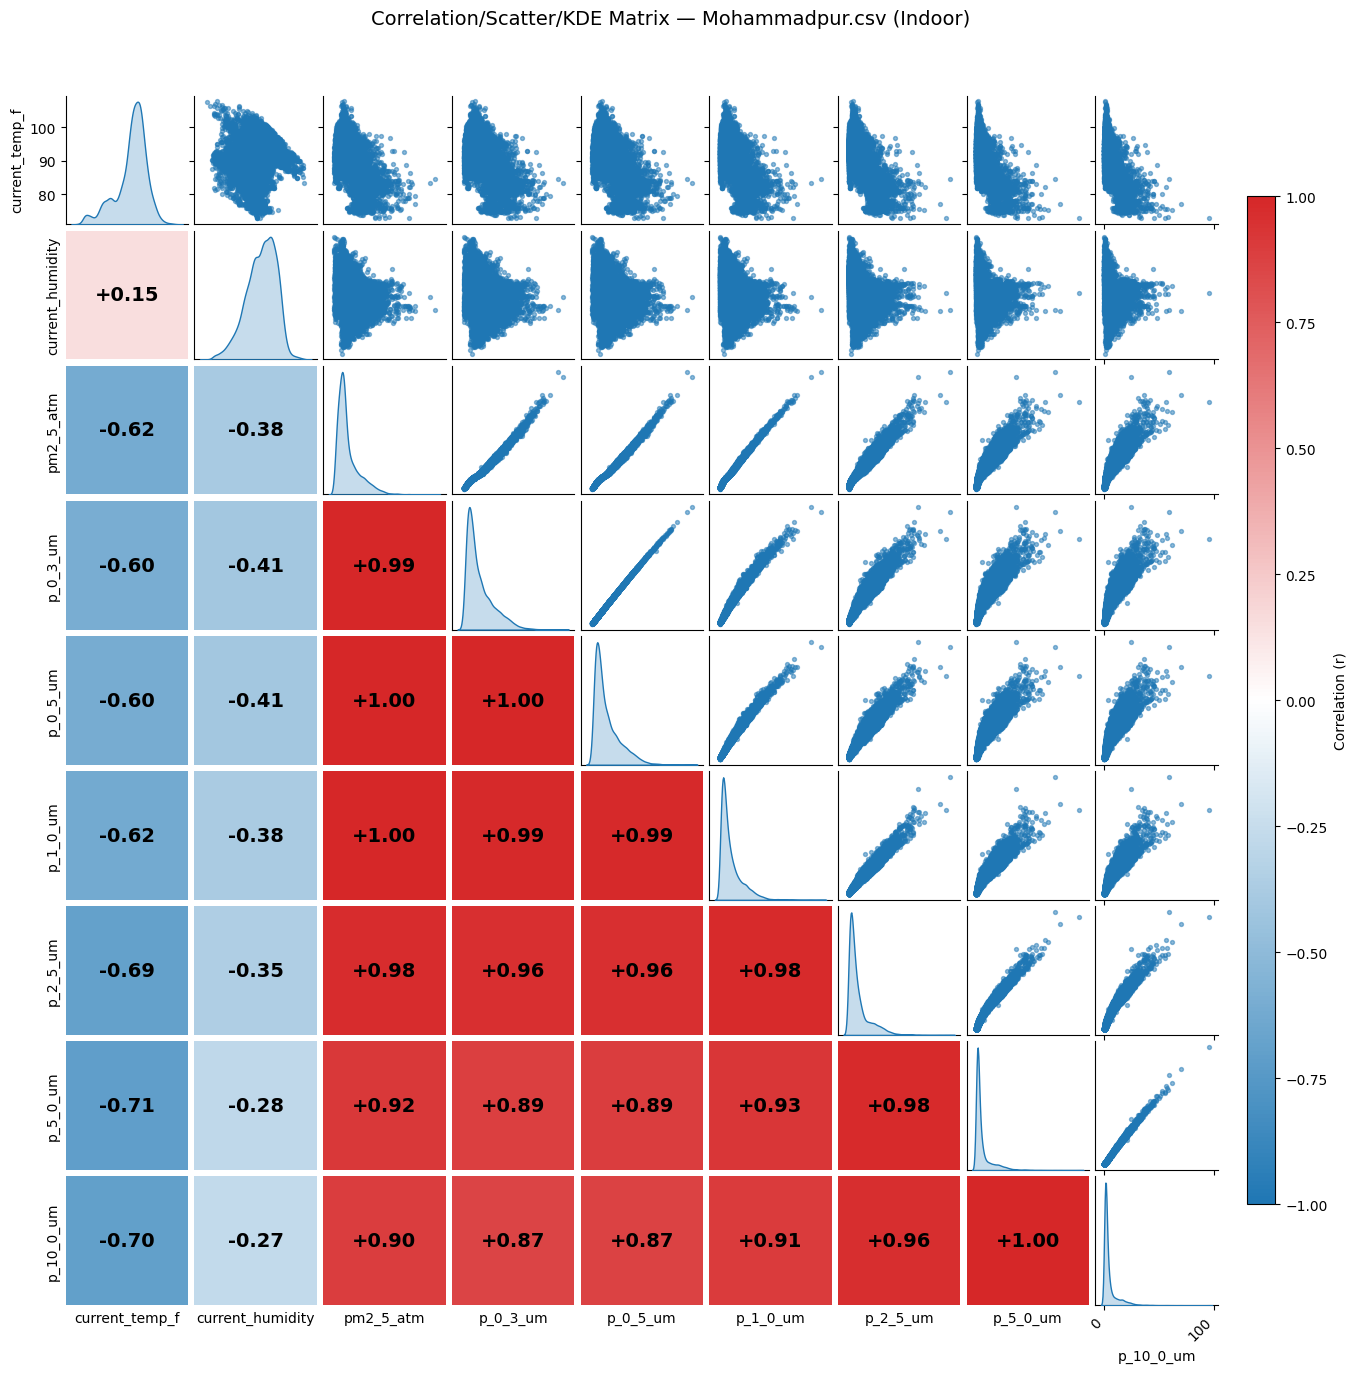

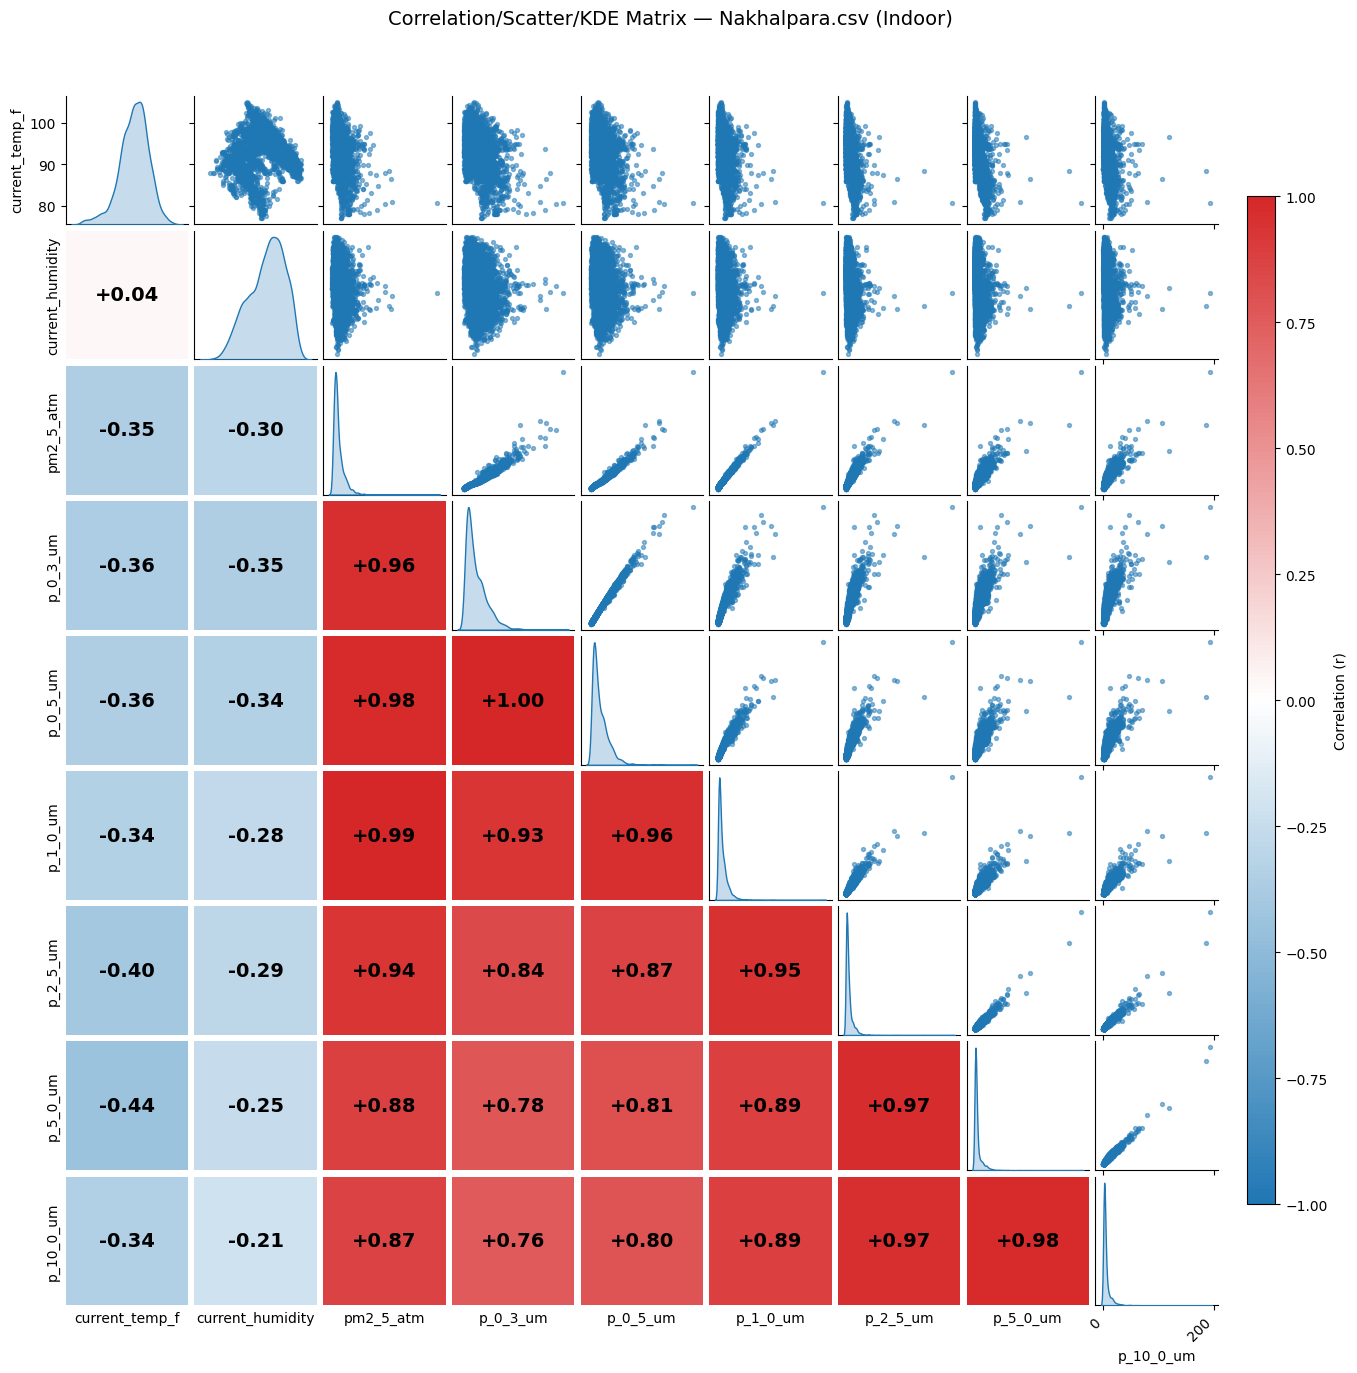

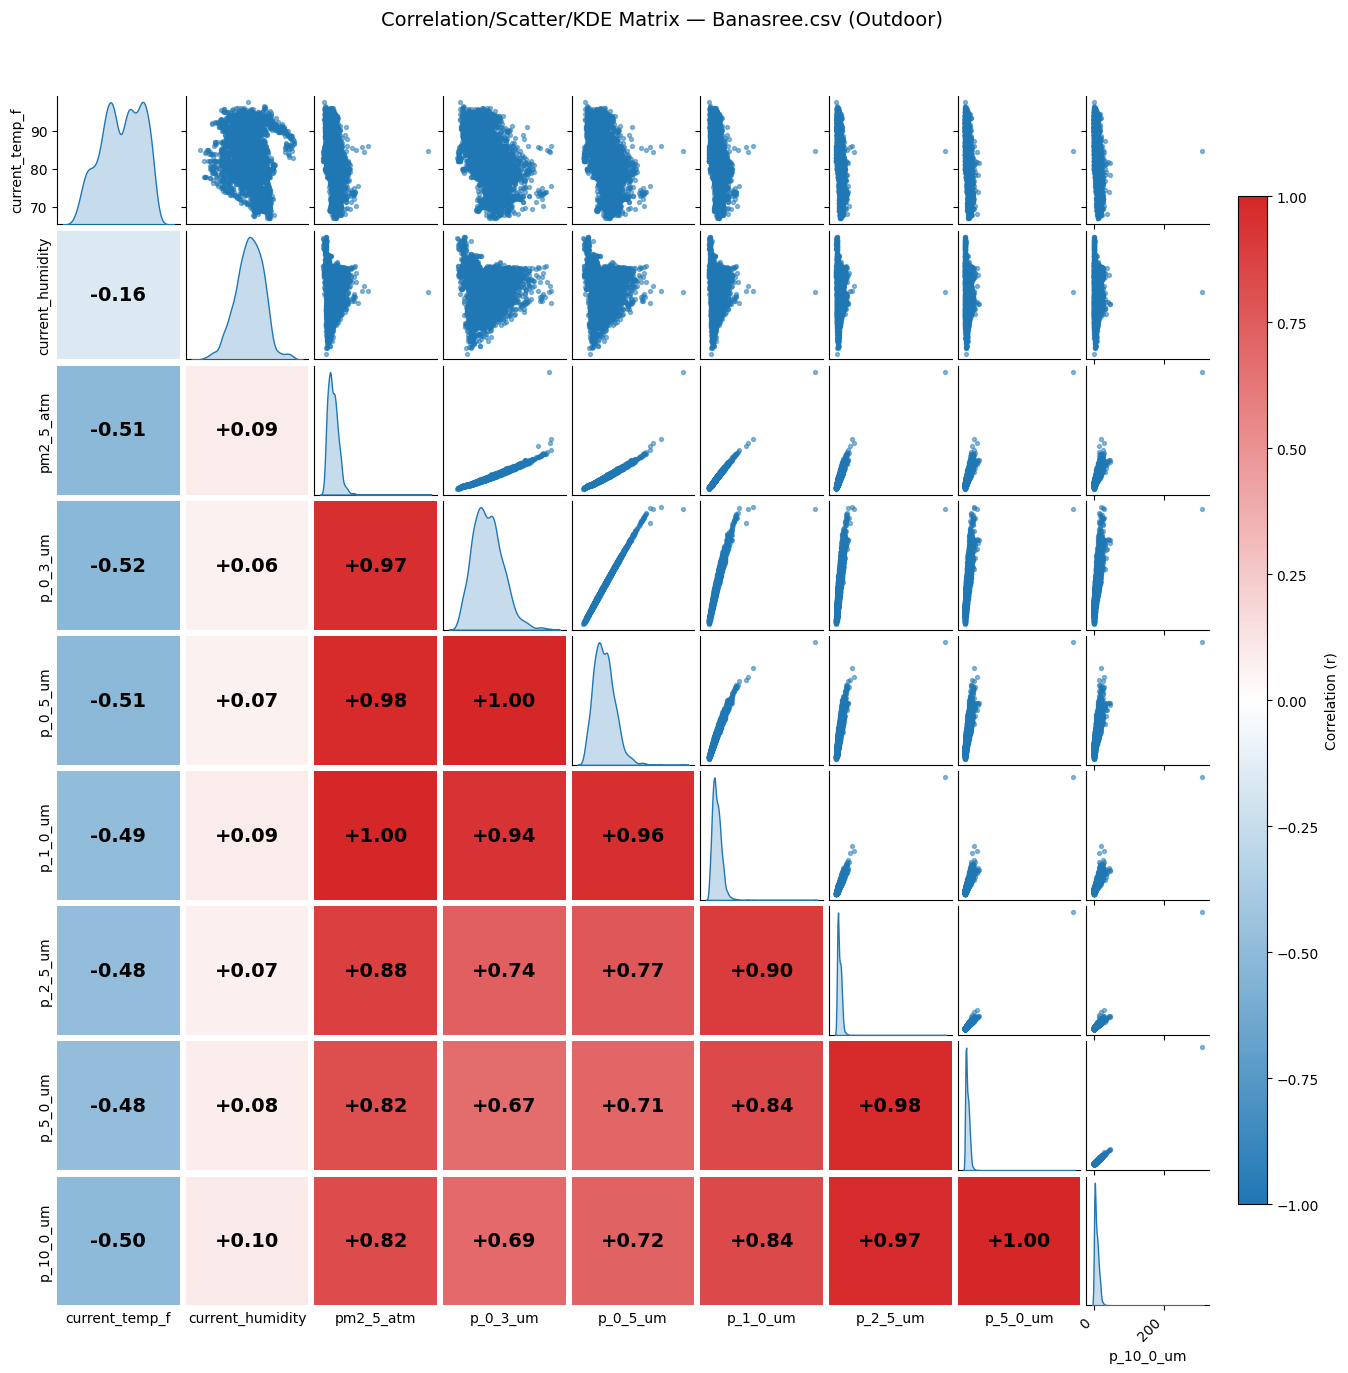

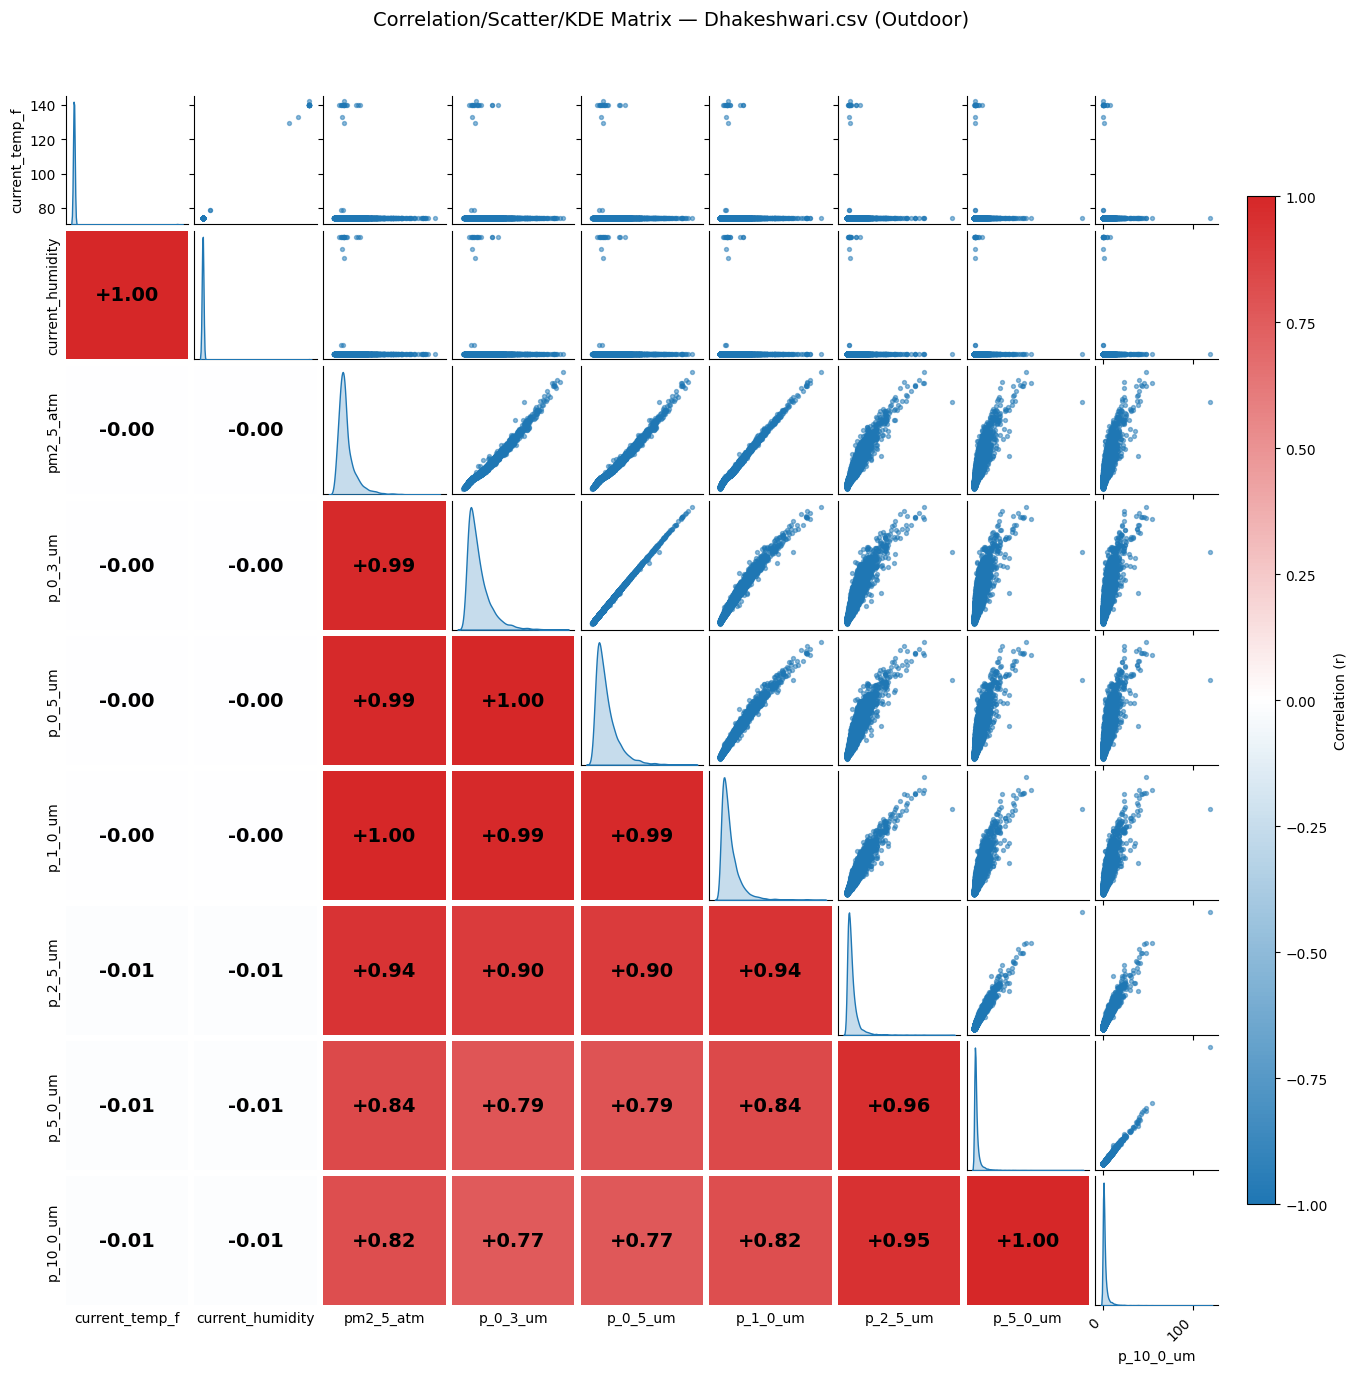

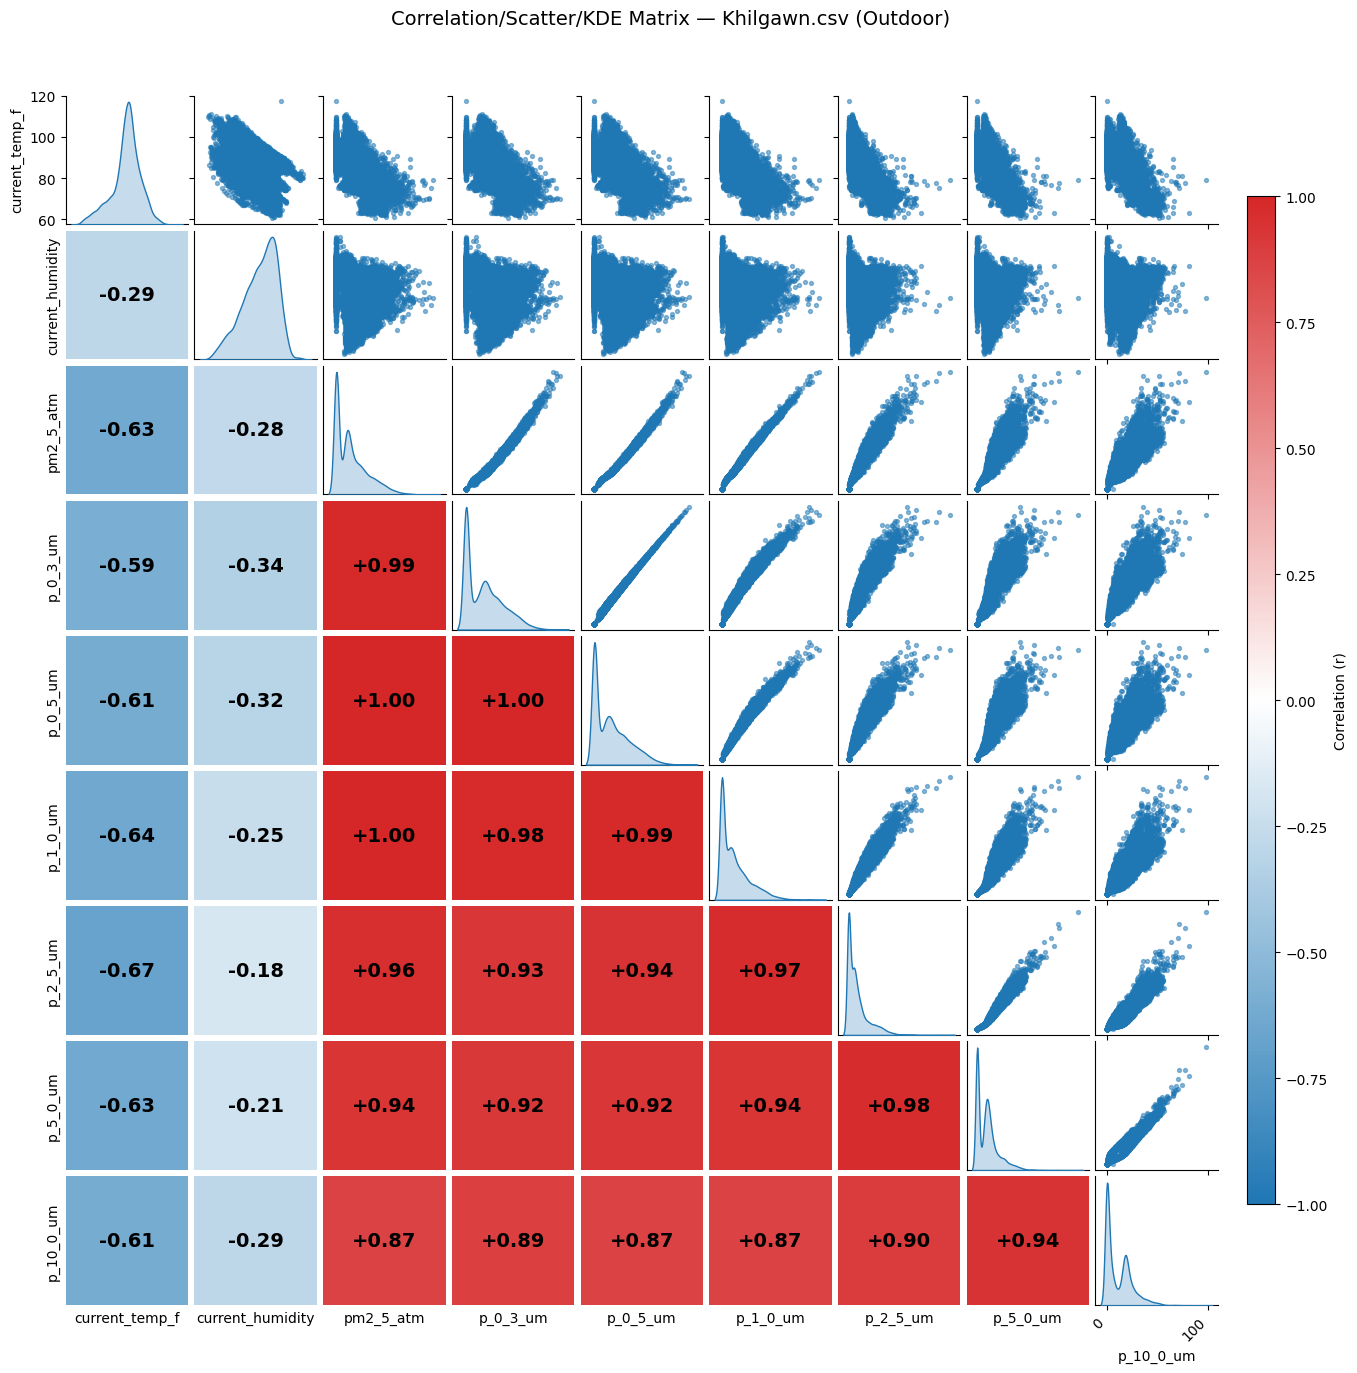

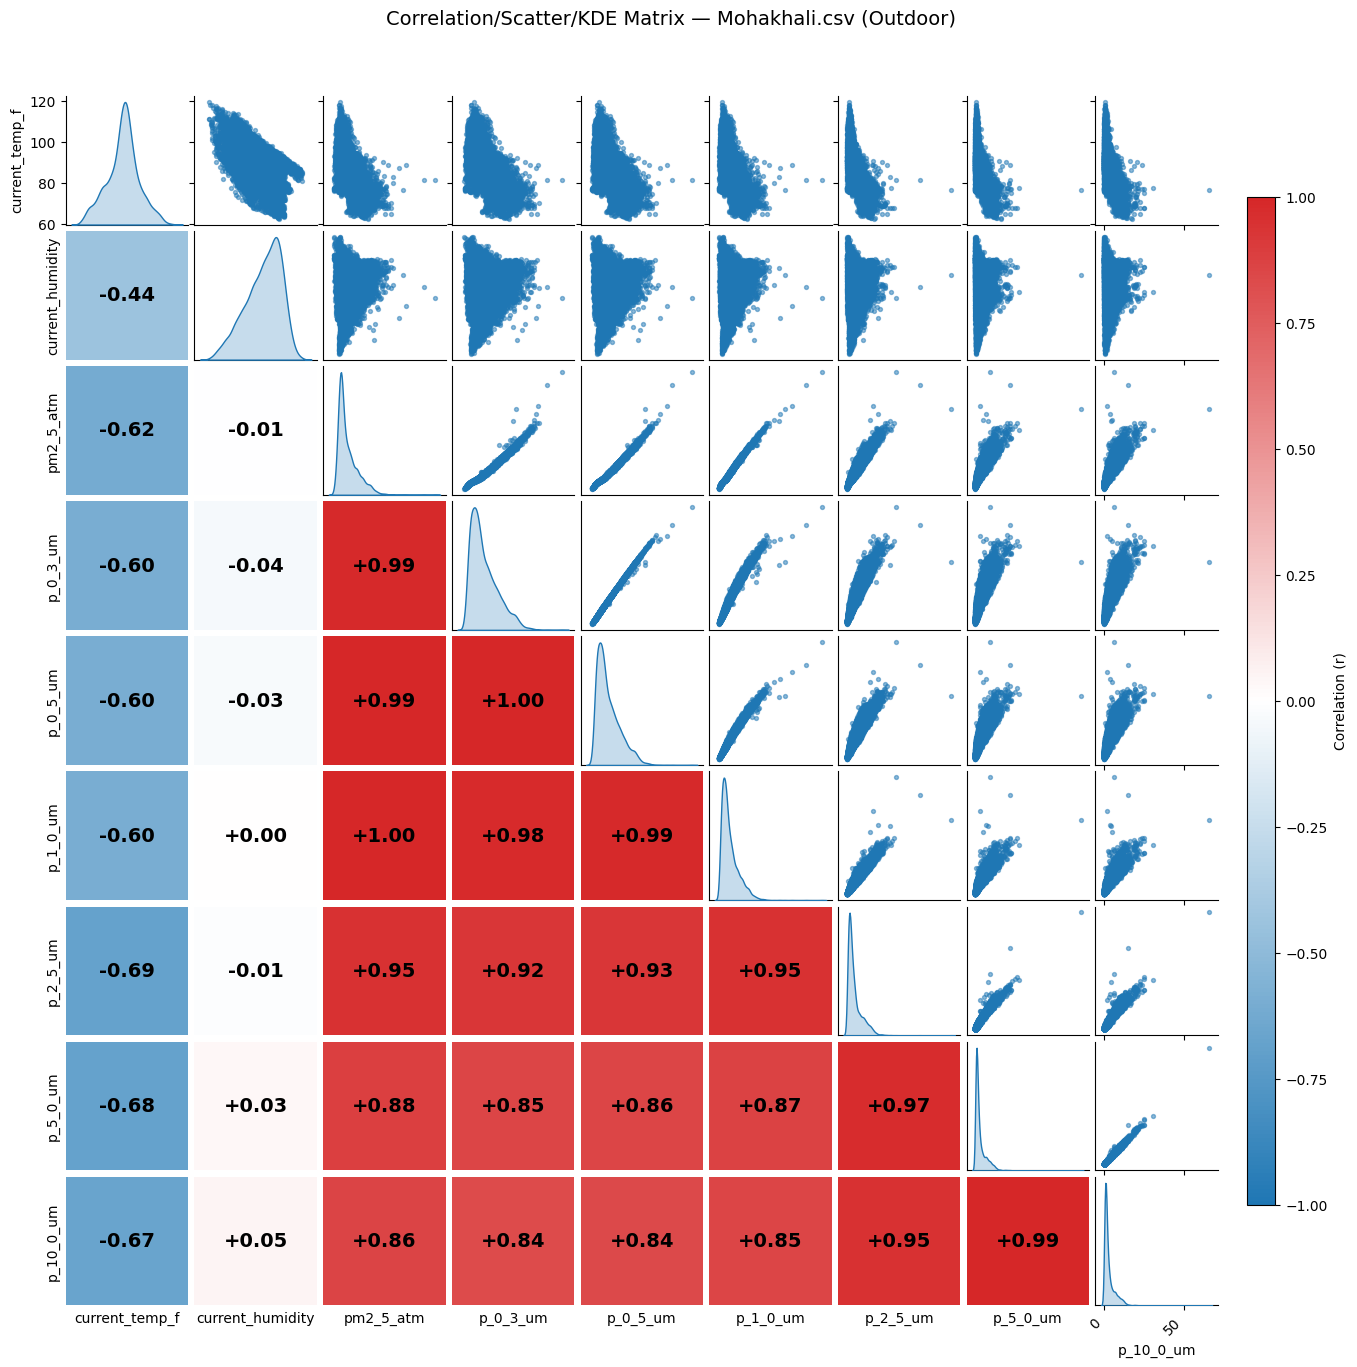

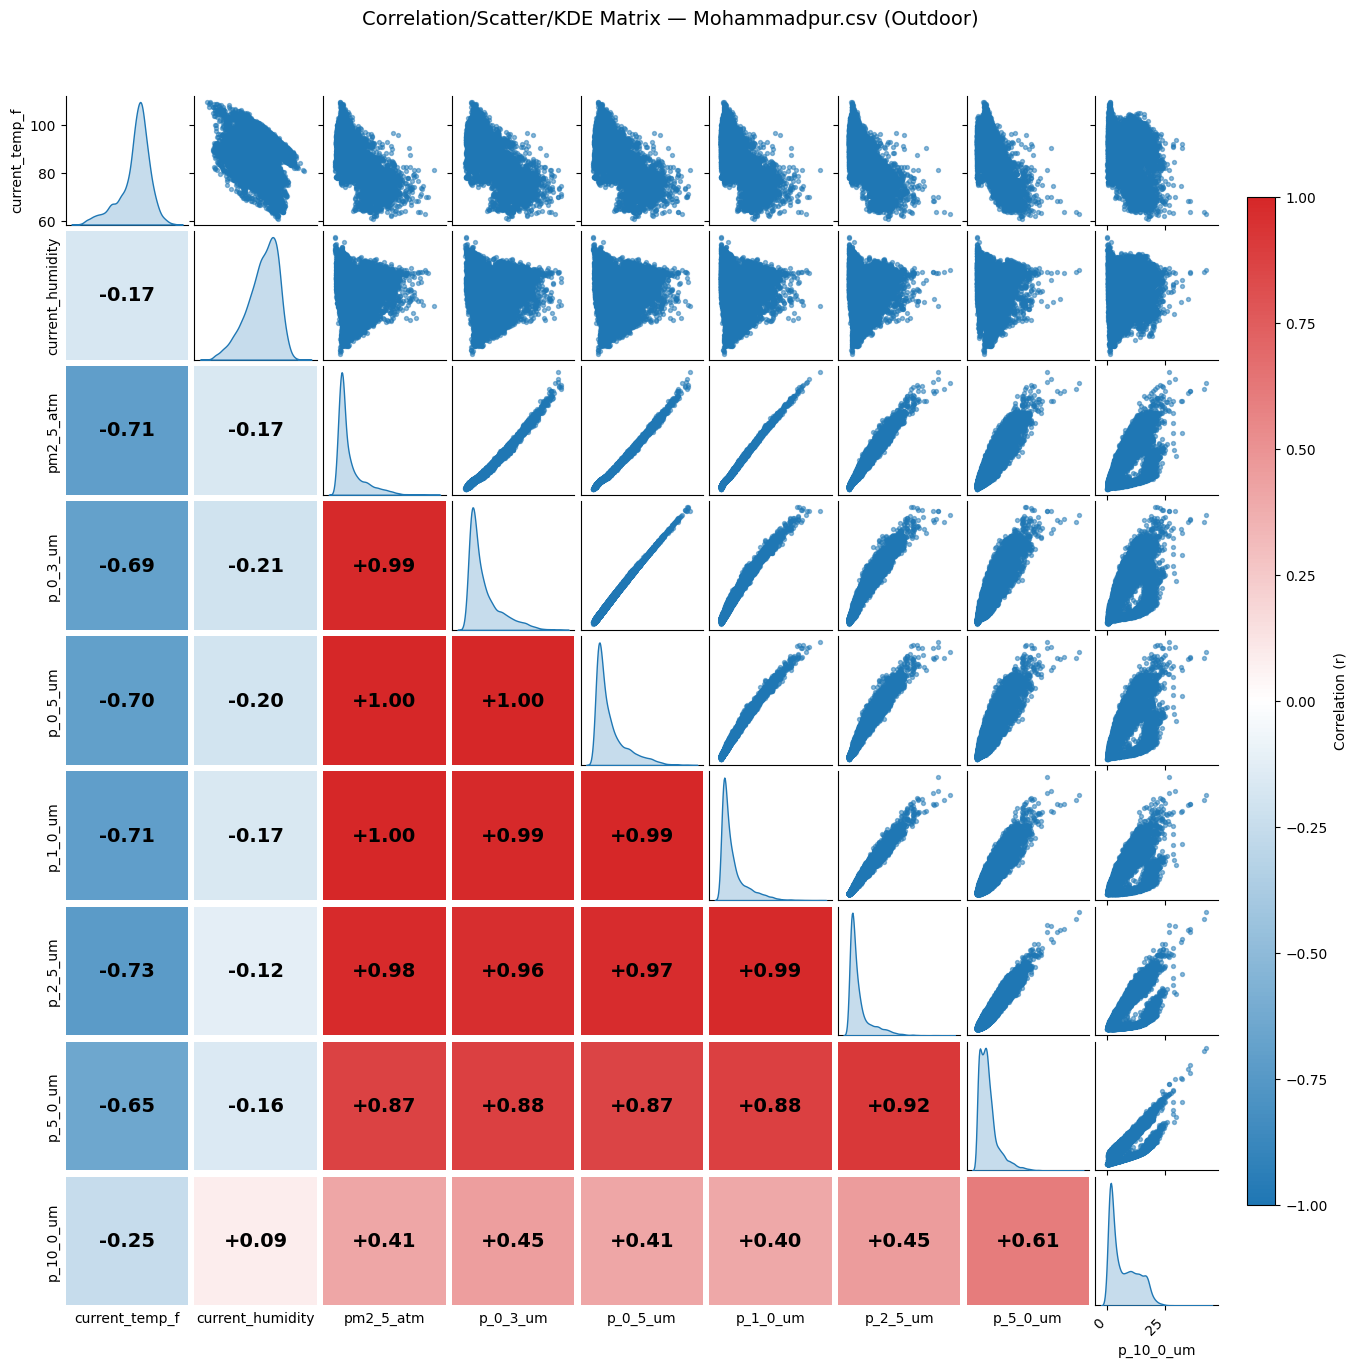

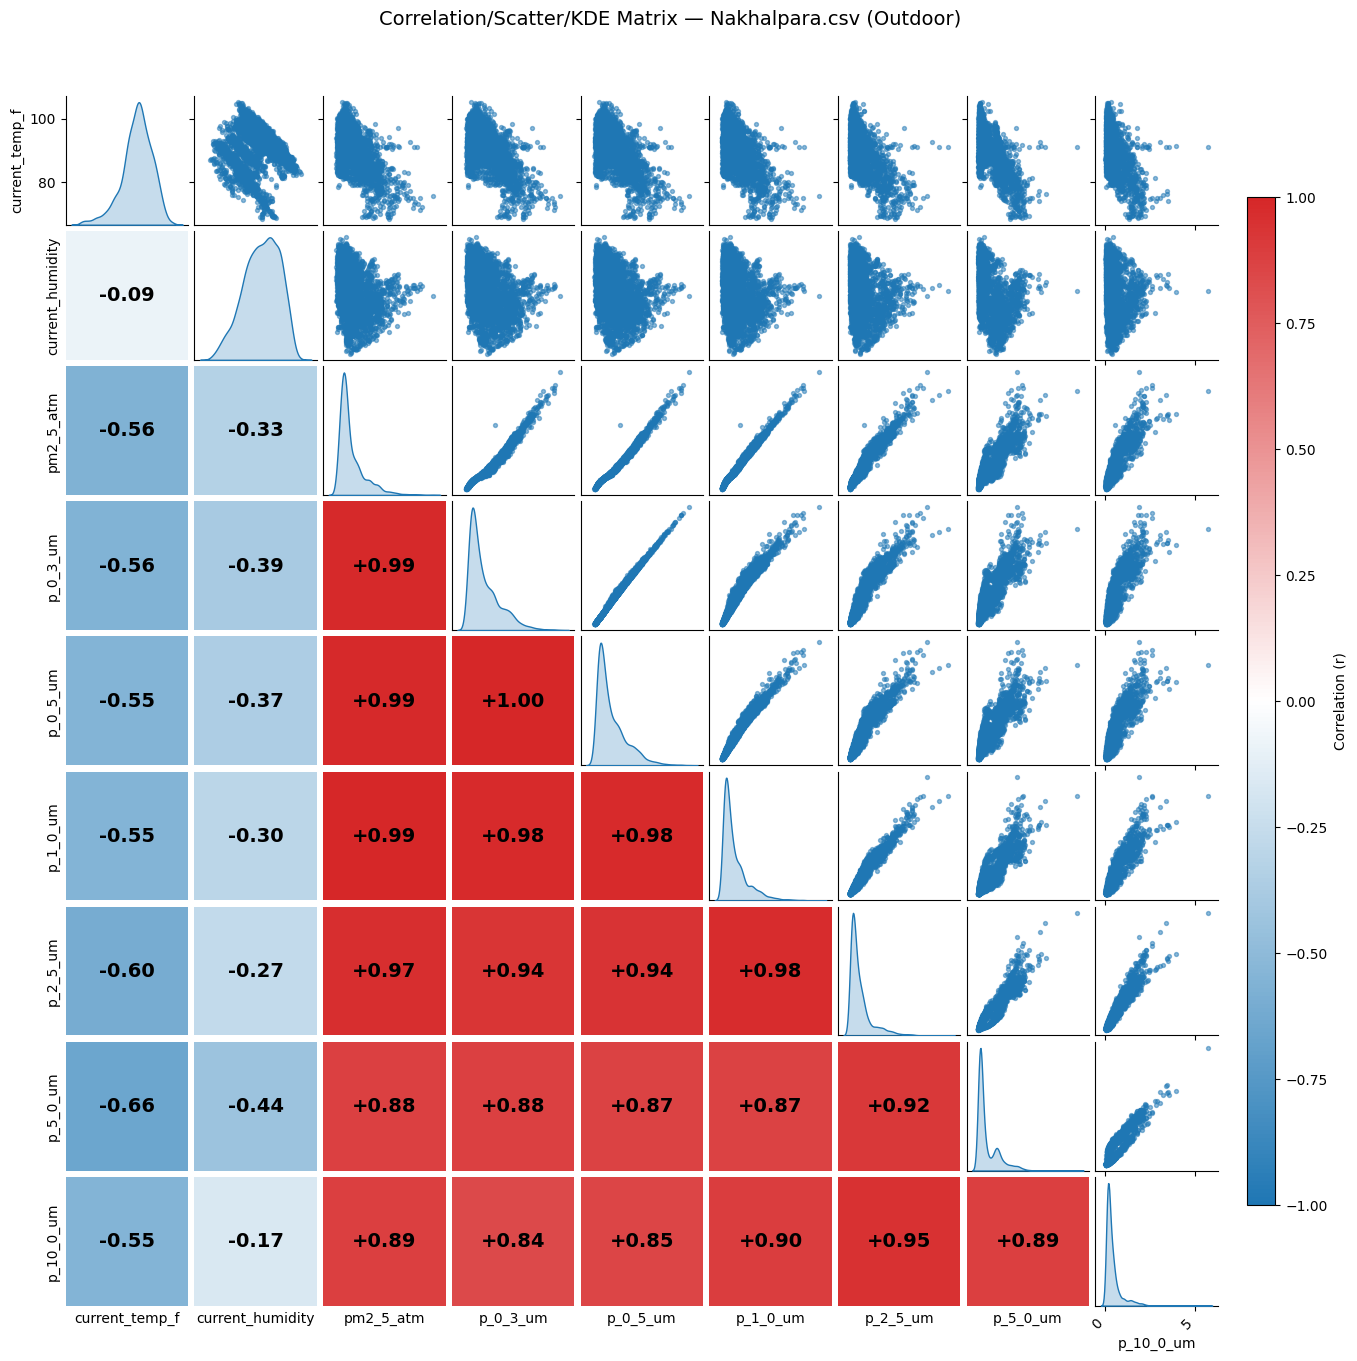

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.cm import ScalarMappable

# --- white at 0, blue for neg, red for pos ---
white_blue_red = LinearSegmentedColormap.from_list(
    "white_blue_red",
    [(0.0, "#1f77b4"),  # -1
     (0.5, "#ffffff"),  #  0
     (1.0, "#d62728")]  # +1
)
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

def diag_kde(x, **kws):
    ax = plt.gca()
    sns.kdeplot(x=x, fill=True, ax=ax)
    ax.set_xlabel(""); ax.set_ylabel("")

def upper_scatter(x, y, **kws):
    ax = plt.gca()
    ax.scatter(x, y, s=8, alpha=0.5)
    ax.set_xlabel(""); ax.set_ylabel("")

def lower_corrtext(x, y, **kws):
    ax = plt.gca()
    r = np.corrcoef(x, y)[0, 1] if len(x) > 1 else np.nan
    ax.set_facecolor(white_blue_red(norm(r))) if np.isfinite(r) else ax.set_facecolor("lightgray")
    ax.text(0.5, 0.5, f"{r:+.2f}" if np.isfinite(r) else "NA",
            ha="center", va="center", fontsize=14, fontweight="bold", transform=ax.transAxes)
    for s in ax.spines.values(): s.set_visible(False)
    ax.set_xticks([]); ax.set_yticks([])

dir = "hourly_averages"
nes_cols = [
    'current_temp_f', 'current_humidity', 'pm2_5_atm',
    'p_0_3_um', 'p_0_5_um', 'p_1_0_um', 'p_2_5_um', 'p_5_0_um', 'p_10_0_um'
]

for env_type in ["Indoor", "Outdoor"]:
    folder = os.path.join(dir, env_type)
    for file in sorted(os.listdir(folder)):
        df = pd.read_csv(os.path.join(folder, file))
        df["time"] = pd.to_datetime(df["time"])
        df.set_index("time", inplace=True)
        df = df[nes_cols].dropna(how="all")
        if df.empty: continue

        # Build grid
        g = sns.PairGrid(df, diag_sharey=False, corner=False, height=1.6)
        g.map_diag(diag_kde)
        g.map_upper(upper_scatter)
        g.map_lower(lower_corrtext)

        # Title
        g.fig.suptitle(f"Correlation/Scatter/KDE Matrix — {file} ({env_type})",
                       fontsize=14)

        # Reserve space for colorbar & title BEFORE adding the cbar
        # left, bottom, right, top margins + spacing
        g.fig.subplots_adjust(left=0.08, right=0.88, bottom=0.08, top=0.92,
                              wspace=0.05, hspace=0.05)

        # Place colorbar in the reserved right margin (doesn't shift grid)
        cax = g.fig.add_axes([0.90, 0.15, 0.02, 0.70])  # [x0, y0, width, height] in figure coords
        sm = ScalarMappable(norm=norm, cmap=white_blue_red); sm.set_array([])
        cb = g.fig.colorbar(sm, cax=cax); cb.set_label("Correlation (r)")

        # Make x labels readable
        for ax in g.axes[-1, :]:
            if ax is not None:
                for label in ax.get_xticklabels():
                    label.set_rotation(45); label.set_ha("right")

        # IMPORTANT: no tight_layout() after colorbar; that’s what displaces things
        # If you want extra packing, use rect to respect the reserved margins:
        # g.fig.tight_layout(rect=[0.08, 0.08, 0.88, 0.92])

        g.fig.savefig(f'graphs/{file} {env_type}.png', dpi=300)
        plt.show()


### Code written by

Rivan Chandra Roy
Bangladesh University of Engineering and Technology